In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [4]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

# redshifts = np.array([4, 5, 6, 7, 8])

# [0.10165, 0.25, 0.35, 0.45, 0.575, 0.725, 0.9][1.65, 2.5, 3.5]
# Ms = np.logspace(7, 12, 60)
Ms = np.linspace(7, 12, 60)


# print(Ms)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

In [5]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [6]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

# print(base_pars)
# This is important!
# base_pars['pop_calib_lum'] = None

In [7]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]', 
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(-1, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, .9),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, -0.01),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[3]')

In [38]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
# logM_0 = 11.0 #(0.01)

mu = 0.019 #(0.002)
N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


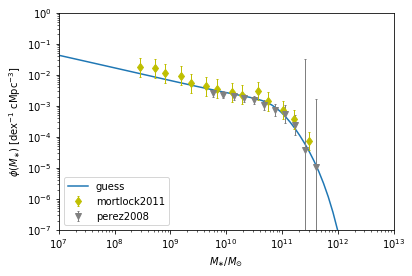

In [39]:
# base_pars
# Ms = np.logspace(7, 12, 60)

base_pars.update(guesses)
pop = ares.populations.GalaxyPopulation(**base_pars)

z = 1.35

smf = pop.StellarMassFunction(z, Ms)
pl.loglog(10**Ms, smf, label='guess')
data.PlotSMF(z=z, round_z=0.2)

pl.legend()
pl.show()

In [40]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.data)

In [41]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [42]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [43]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 30

fitter.jitter = [0.1] * len(fitter.parameters)
# fitter.jitter = [0.01, 0.01, 0.001, 0.005, 0.01, 0.01, 0.04, 0.01]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops
# nwalkers

# Fixing position of walker 0 (parameter pq_func_par0[1])
# Moved from -0.09659435492759859 to 0.09366940868187423
# Fixing position of walker 1 (parameter pq_func_par0[1])
# Moved from -0.05829911268516026 to 0.09184061263195266
# Fixing position of walker 8 (parameter pq_func_par0[1])
# Moved from -0.0784898884208276 to 0.14960349118314314
# Fixing position of walker 11 (parameter pq_func_par0[1])
# Moved from -0.025160357608248304 to 0.06636859513379435
# Fixing position of walker 14 (parameter pq_func_par0[1])
# Moved from -0.025224328835808992 to 0.0725446515403004
# Fixing position of walker 16 (parameter pq_func_par0[1])
# Moved from -0.040722901413921805 to 0.11694162316512573
# Fixing position of walker 18 (parameter pq_func_par0[1])
# Moved from -0.11902015902119892 to 0.14960349118314314
# Fixing position of walker 19 (parameter pq_func_par0[1])
# Moved from -0.032390241194572456 to 0.07611685344569666
# Fixing position of walker 22 (parameter pq_func_par0[1])
# Moved from -

In [ ]:
# Run the thing
fitter.run('MCMC_files/test_smfcal_2', burn=5, steps=45, save_freq=1, clobber=True)

Saved HaloMassFunction instance to limit I/O.
# Starting burn-in: Thu Jul  2 11:40:29 2020
# Wrote MCMC_files/test_smfcal_2.burn.dd0000.facc.pkl: Thu Jul  2 11:42:10 2020
# Wrote MCMC_files/test_smfcal_2.burn.dd0001.facc.pkl: Thu Jul  2 11:42:55 2020
# Wrote MCMC_files/test_smfcal_2.burn.dd0002.facc.pkl: Thu Jul  2 11:43:37 2020
# Wrote MCMC_files/test_smfcal_2.burn.dd0003.facc.pkl: Thu Jul  2 11:44:17 2020
# Wrote MCMC_files/test_smfcal_2.burn.dd0004.facc.pkl: Thu Jul  2 11:44:58 2020
# Burn-in complete in 269 seconds.
# Fixing position of walker 0 (parameter pq_func_par0[1])
# Moved from -0.11528727762709645 to 0.11564708105630987
# Fixing position of walker 2 (parameter pq_func_par0[1])
# Moved from -0.015968689978532957 to 0.02561749222244545
# Fixing position of walker 4 (parameter pq_func_par0[1])
# Moved from -0.0008241262640391774 to 0.029582680958852255
# Fixing position of walker 7 (parameter pq_func_par0[1])
# Moved from -0.03119393272188143 to 0.11564708105630987
# Fixing p

In [26]:
anl = ares.analysis.ModelSet('MCMC_files/test_smfcal_1')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run5')

labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels
# anl.custom_labels


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : MCMC_files/                                                                            ####
#### prefix      : test_smfcal_1                                                                          ####
#### N-d         : 8                                                                                      ####


# Loading MCMC_files/test_smfcal_1.dd*.chain.pkl...
# Loaded MCMC_files/test_smfcal_1.dd*.chain.pkl in 0.34 s.
# Loaded MCMC_files\test_smfcal_1.dd0000.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0001.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0002.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0003.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0004.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0005.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0006.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0007.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0008.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0009.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0010.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0011.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0012.blob_2d.galaxy_smf.pkl
# Loaded MCMC_files\test_smfcal_1.dd0013.blob_2d.galaxy_s

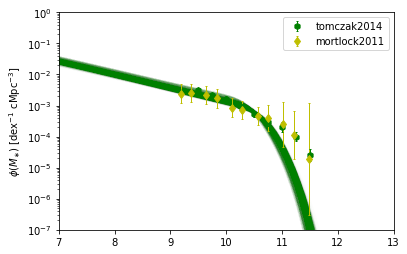

In [27]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 2.25
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='g', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.semilogy()

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [28]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.054866e+00
pq_func_par2[0]: 1.493706e-01
pq_func_par0[1]: 1.893834e-02
pq_func_par2[1]: -6.970138e-01
pq_func_par0[2]: 5.736140e-01
pq_func_par2[2]: -2.324861e-01
pq_func_par0[3]: 1.178484e+01
pq_func_par2[3]: 2.117509e-02


0 of 1350 chain elements ignored because of chain links with inf's/nan's.


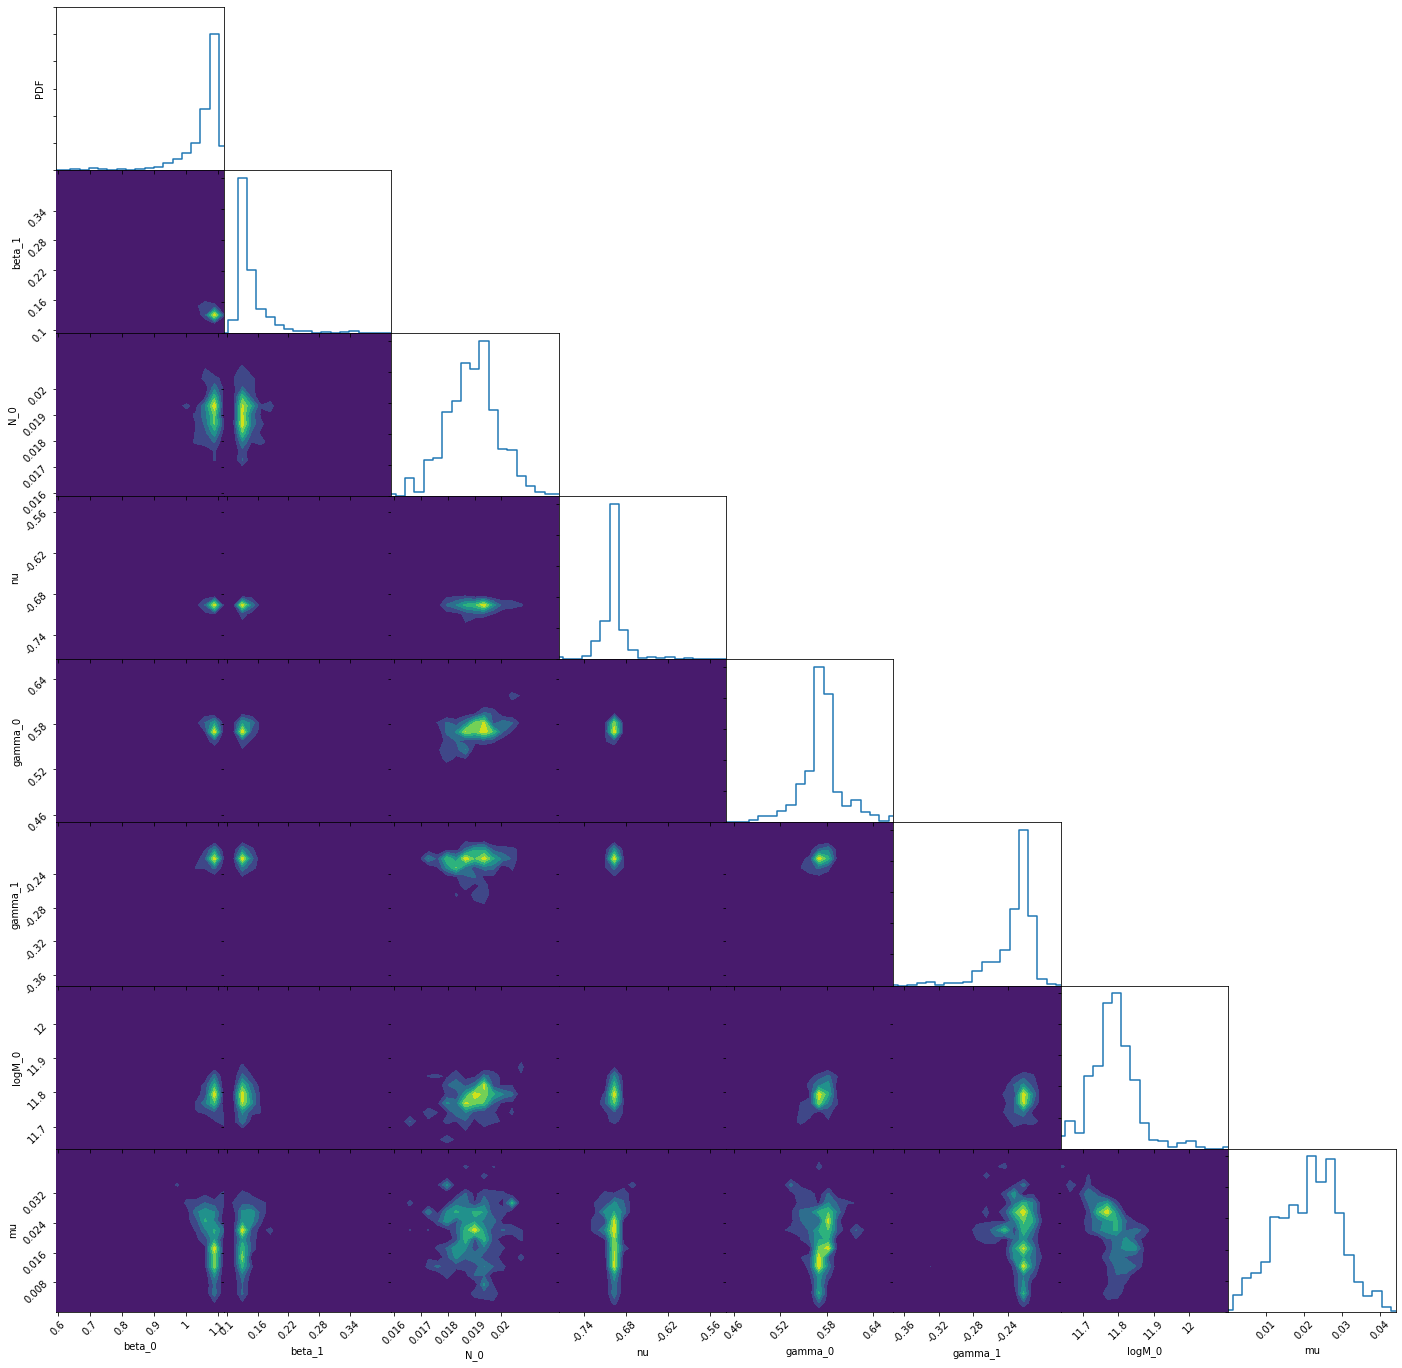

In [30]:

trig = anl.TrianglePlot(pars=params)

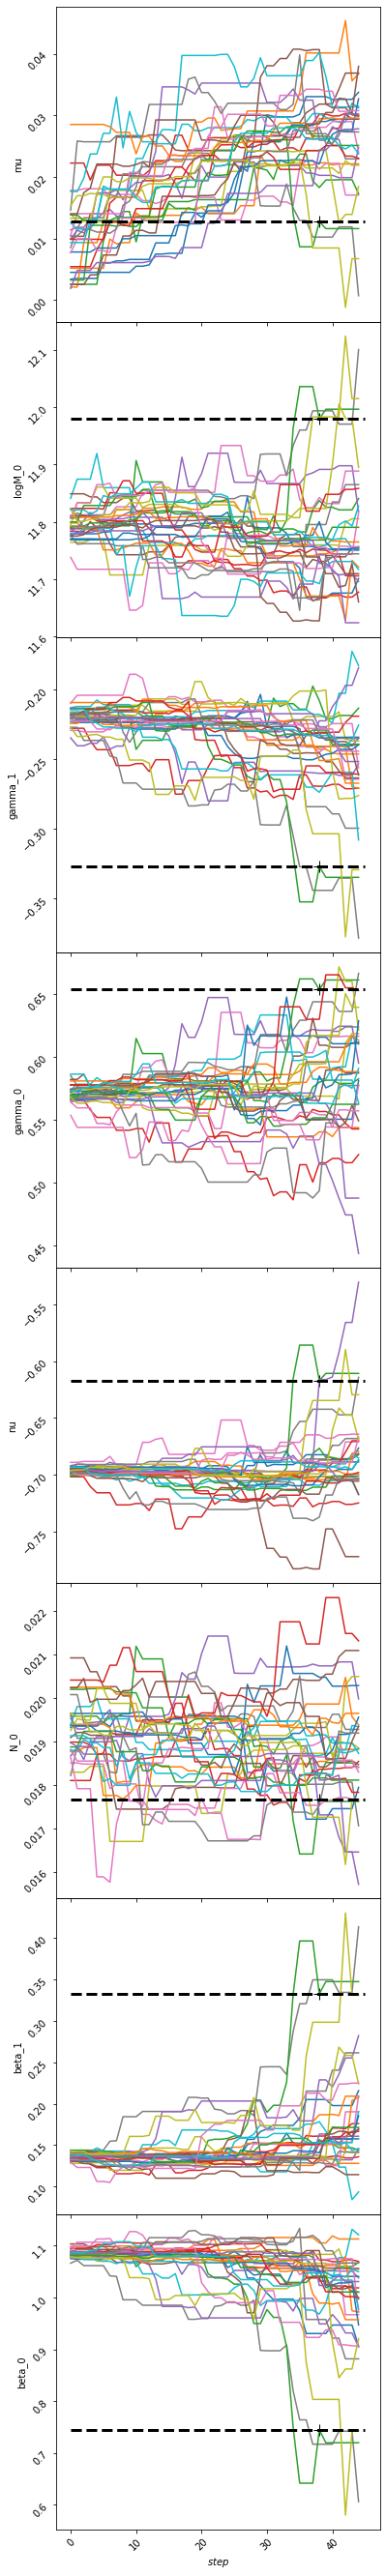

In [29]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

In [31]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 0.7447410020121565,
 'pq_func_par2[0]': 0.3325603230935028,
 'pq_func_par0[1]': 0.017670271191534373,
 'pq_func_par2[1]': -0.617125460189753,
 'pq_func_par0[2]': 0.6539927693569566,
 'pq_func_par2[2]': -0.32688976997802005,
 'pq_func_par0[3]': 11.979514926585725,
 'pq_func_par2[3]': 0.012706855220786569}

In [32]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.054866e+00
pq_func_par2[0]: 1.493706e-01
pq_func_par0[1]: 1.893834e-02
pq_func_par2[1]: -6.970138e-01
pq_func_par0[2]: 5.736140e-01
pq_func_par2[2]: -2.324861e-01
pq_func_par0[3]: 1.178484e+01
pq_func_par2[3]: 2.117509e-02


In [33]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [34]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(0.7447410020121565, array([ 0.34867982, -0.27132046]))
(0.3325603230935028, array([-0.16453865,  0.20409074]))
(0.017670271191534373, array([ 0.00214441, -0.00032639]))
(-0.617125460189753, array([-0.07145851,  0.09029382]))
(0.6539927693569566, array([-0.06221622,  0.10234836]))
(-0.32688976997802005, array([ 0.11188968, -0.07461216]))
(11.979514926585725, array([-0.14056272,  0.2514942 ]))
(0.012706855220786569, array([1.62947467e-02, 2.33766239e-05]))


In [35]:
pars_best = ares.util.ParameterBundle("emma:model1")
pars = ares.util.ParameterBundle("emma:model1")

# print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


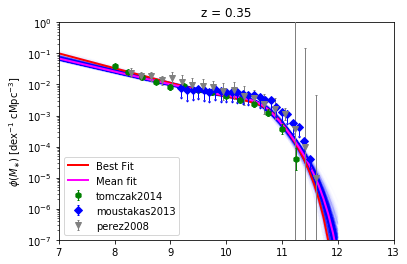

In [36]:
z = 0.35

# Ms_short = np.logspace(7, 13, 80)

# print(Ms)

ls_best = pop_best.StellarMassFunction(z, Ms)
ls_mean = pop_mean.StellarMassFunction(z, Ms)

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)

# print(ls_best)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

ax.semilogy(Ms, ls_best, label='Best Fit', color="red", linewidth=2)
pl.semilogy(Ms, ls_mean, label='Mean fit', color="magenta", linewidth=2)

pl.title("z = %.2f" %z)
pl.legend()
# pl.ylim(1e-18, 1e2)
pl.show()

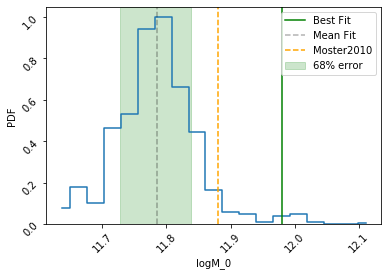

In [37]:
bests = [anl.get_1d_error(i, nu=0.68,  peak='mode') for i in params]

i = 6

ax = anl.PosteriorPDF(pars=params[i])

pl.axvline(x=bests[i][0], ls="-", color="green", label="Best Fit")

ax.axvspan(bests[i][0]-bests[i][1][1], bests[i][0]+bests[i][1][0], alpha=0.2, color='green' ,label="68% error")

pl.axvline(x=fit_mean[i], ls="--", color="black", label="Mean Fit", alpha=0.3)
pl.axvline(x=pars[params[i]], ls="--", color="orange", label="Moster2010")


pl.legend()
pl.show()